### Lens mass and source light reconstruction with substructure 

This notebook demonstrates how to perform lens mass/source light reconstruction with thousands of dark subhalos and line of sight halos included in the lens model. This task is computationally intractable with exact ray-tracing, so we use an approximation for multi-plane ray tracing that decouples the deflections from halos at redshift $z > z_{\rm{main}}$ from the deflections produced in the main lens plane (we assume there is one massive deflector(s) at $z=z_{\rm{main}}$). This effectively turns the multi-plane realization into a single-plane realization, and leads to an increase in speed by a significant (~100-1000x) amount. 

The decoupled multi-plane approximation generates a deflection field associated with halos at z > z_lens by full ray-tracing, and then applies these deflections in all subsequent calls to the ray tracing functions in lenstronomy. If you have a good initial guess of what the "true" lens model is at $z_{\rm{main}}$, you will have a very good approximation of the true non-linear deflection field. 

This approximation should be valid when you are interested in computing obervables (lensed light surface brightness, flux ratios) or properties of the lens system (parameters that describe the macromodel) with substructure in the model, but you are not interested in constraining the physical properties of the substructures themselves. This is because we replace physical properties of halos with an effective deflection field that does not correspond to a an actual configuration of deflectors. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.Util.param_util import ellipticity2phi_q
from quadmodel.inference.forward_model_packaged import ForwardModelSimulation
from quadmodel.data.quad_base import Quad
import os
from copy import deepcopy

### Create some simulated data

Here will assume HST-like data

[4.15346824 6.11554459 4.25963411 3.77858321]
[1.47239469 1.02556078 0.90974169]


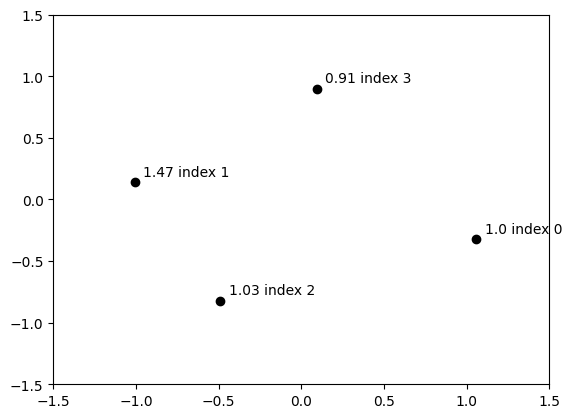

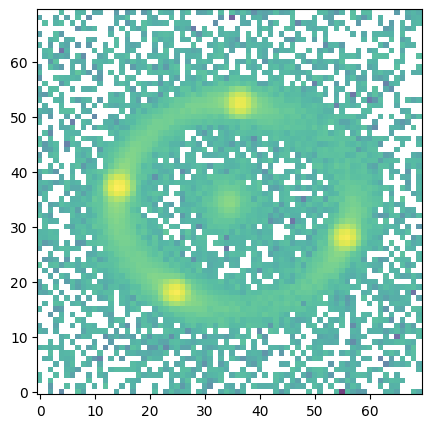

In [2]:
zlens = 0.5
zsource = 2.5
# data specifics
background_rms = 0.006  # background noise per pixel
exp_time = 5400.0  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
window_size = 3.5
numPix = int(window_size/deltaPix)
fwhm = 0.1  # full width half max of PSF

# PSF specification
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 5}
psf_class = PSF(**kwargs_psf)

# macromodel specification
e1, e2 = -0.07, 0.15
phi_m, q = ellipticity2phi_q(e1, e2)
lens_model_list_macro = ['EPL', 'SHEAR']
kwargs_lens_macro = [{'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': e1, 'e2': e2,'gamma':2.03},
                {'gamma1': 0.05,'gamma2':0.04}]
lens_model_macro = LensModel(lens_model_list_macro)

# lens light model
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 5, 'R_sersic': 0.25, 'n_sersic': 4.0, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# source light model
ra_source = 0.044
dec_source = -0.03
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [{'amp': 20, 'R_sersic': 0.1, 'n_sersic': 4.0, 'center_x': ra_source, 'center_y': dec_source,
                  'e1': 0., 'e2': 0.1}]
source_model_class = LightModel(light_model_list=source_model_list)

# compute image positions and magnifications
lensEquationSolver = LensEquationSolver(lens_model_macro)
x_image, y_image = lensEquationSolver.image_position_from_source(ra_source, dec_source, kwargs_lens_macro)
ext = LensModelExtensions(lens_model_macro)
source_size = 5.0 # parsec
mag_midIR = ext.magnification_finite_adaptive(x_image, y_image, ra_source, dec_source, 
                                              kwargs_lens_macro, source_size, zsource)
mag_midIR = np.abs(mag_midIR)  # ignore the sign of the magnification
print(mag_midIR)
print(mag_midIR[1:]/mag_midIR[0])
for i, (xi, yi, mi) in enumerate(zip(x_image, y_image, mag_midIR/mag_midIR[0])):
    plt.scatter(xi, yi, color='k')
    plt.annotate(str(np.round(mi,2))+' index '+str(i), xy=(xi+0.05, yi+0.05))
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5) 
plt.show()

# setup data class
source_brightness_intrinsic = 10.0
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': mag_midIR * source_brightness_intrinsic}]  
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 2, 'supersampling_convolution': False}
imageModel = ImageModel(data_class, psf_class, lens_model_macro, source_model_class,
                               lens_light_model_class,
                               point_source_class, kwargs_numerics=kwargs_numerics)
image_sim_raw = imageModel.image(kwargs_lens_macro, kwargs_source, kwargs_lens_light, kwargs_ps)
image_sim = imageModel.image(kwargs_lens_macro, kwargs_source, kwargs_lens_light, kwargs_ps)
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

_r = np.linspace(-window_size/2, window_size/2, numPix)
_xx, _yy = np.meshgrid(_r, _r)
inds = np.where(np.hypot(_xx, _yy)>3.0)
mask = np.ones_like(kwargs_data['image_data'])
mask[inds] = 0.0
shape0 = _xx.shape
kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

fig = plt.figure(1)
fig.set_size_inches(12, 5)
ax1 = plt.subplot(111)
ax1.imshow(np.log10(image_sim * mask), origin='lower', alpha=0.75)

### Now create a population of subhalos with pyHalo 

Install the source code from here: https://github.com/dangilman/pyHalo, or "pip install pyhalo"

In this realization I boost the concentration of all halos by a factor of 10 so that they have a more obvious effect on the imaging data and lens model (otherwise it's hard to tell they are there, given the assumptions about the imaging data resolution). 

Note that in this cell I am removing all halos and subhalos at z <= z_lens. This is really just to showcase the improvement in speed from the decopuled multi-plane formalism. One could, in principle, optimize ray tracing for halos at z <= z_lens such that calculations run at the same speed as a single-plane calculation (this is because the deflections caused by halos at z < z_lens do not depend on deflections produced in the main lens plane)

In [3]:
from pyHalo.concentration_models import ConcentrationDiemerJoyce

# here we can optionally remove halos in front of and in the same lens plane as the main deflector
KEEP_ONLY_BACKGROUND_HALOS = True

rescale_halo_concentrations = 10.0 # settings this equal to 1 implements a regular CDM concentration-mass relation
rescale_slope = 0.0
class RescaledDiemerJoyce(object):
    # we create this class to make halos more concentrated so they make visible distortions on the image data
    def __init__(self, cosmo, rescale_amp, scatter_dex=0.2):
        self._model_diemer_joyce = ConcentrationDiemerJoyce(cosmo, scatter=False)
        self._rescale_amp = rescale_amp
        self._scatter_dex = scatter_dex

    def _rescale_factor(self, m):
        return self._rescale_amp 

    def nfw_concentration(self, m, z):
        rescale_c = self._rescale_factor(m)
        c = rescale_c * self._model_diemer_joyce.nfw_concentration(m, z)
        log_c = np.log(c)
        c = np.random.lognormal(log_c, self._scatter_dex)
        return c

seed = 42
np.random.seed(seed)
shmf_norm = 0.05
LOS_norm = 1.0
log_mlow = 6.0
kwargs_mass_sheet = {'log_mlow_sheets': log_mlow}
from pyHalo.preset_models import CDM
kwargs_concentration_model = {'custom_class': RescaledDiemerJoyce, 
                              # can optionally boost concentrations 
                              'rescale_amp': rescale_halo_concentrations
                             }
_cdm_realization = CDM(zlens, zsource, log_mlow=log_mlow, 
                      sigma_sub=0.05, 
                      LOS_normalization=1.0,
                     cone_opening_angle_arcsec=2.5*window_size, 
                     concentration_model_subhalos='CUSTOM', 
                     concentration_model_fieldhalos='CUSTOM', 
                     kwargs_concentration_model_subhalos=kwargs_concentration_model,
                     kwargs_concentration_model_fieldhalos=kwargs_concentration_model)
if KEEP_ONLY_BACKGROUND_HALOS:
    # lets keep background halos only
    _, cdm_realization = _cdm_realization.split_at_z(zlens)
else:
    cdm_realization = _cdm_realization
lens_model_list_halos, redshift_array_halos, kwargs_halos, _ = cdm_realization.lensing_quantities(
        kwargs_mass_sheet=kwargs_mass_sheet)
print('REALIZATION CONTAINS '+str(len(lens_model_list_halos))+' halos.')
lens_model_list = lens_model_list_macro + lens_model_list_halos
redshift_list = [zlens] * 2 + list(redshift_array_halos)
kwargs_lens = kwargs_lens_macro + kwargs_halos
lens_model_multiplane = LensModel(lens_model_list, lens_redshift_list=redshift_list, z_source=zsource, 
                             multi_plane=True)

REALIZATION CONTAINS 4844 halos.


### Setup the decoupled multi-plane model

Using a proposed set of deflection angles from the main lens plane, we ray trace to the source plane to compute an effective deflection field from halos in between the lens and source. We then keep this deflection field fixed, and apply it across the main lens plane for subsequent ray tracing calculations. This effectively creates a single plane lens model with a non-linear distortion applied to rays that leave the main lens plane according to the multi-plane lens equation with our intial proposed set of deflection angles. 

In [4]:
from lenstronomy.LensModel.Util.decouple_multi_plane_util import *

# set up the grid for interpolation
grid_size = window_size
# this is the grid resolution we use to ray-trace through the lens volume when setting up the interpolated deflection field. When
# super-sampling, you should increase this resolution accordingly
grid_resolution = 0.05 
x_grid, y_grid, interp_points, npix = setup_grids(grid_size, grid_resolution)

# here we break off the first two lens models (the macromodel) from the rest of the line of sight 
index_lens_split = [0, 1]

lens_model_fixed, lens_model_free, kwargs_lens_fixed, kwargs_lens_free, z_source, z_split, cosmo_bkg = \
setup_lens_model(lens_model_multiplane, kwargs_lens, index_lens_split)

# do the interpolation of the deflection fields 
xD, yD, alpha_x_foreground, alpha_y_foreground, alpha_beta_subx, alpha_beta_suby = coordinates_and_deflections(lens_model_fixed, lens_model_free, kwargs_lens_fixed, kwargs_lens_free,
                                x_grid, y_grid, z_split, z_source, cosmo_bkg)

# set up the new lens model
kwargs_class_setup = class_setup(lens_model_free, xD, yD, alpha_x_foreground, \
                                                                 alpha_y_foreground, alpha_beta_subx, \
                                                                 alpha_beta_suby, z_split, \
                                                                 coordinate_type='GRID', \
                                                                 interp_points=interp_points)

### Lets have a look at the substructure in the lens system
Ray-tracing with the new model is now about 600 times faster. This cell is for visualization only

time for full ray-tracing:  20.69656801223755
time for decoupled ray-tracing:  0.0813288688659668
EXACT


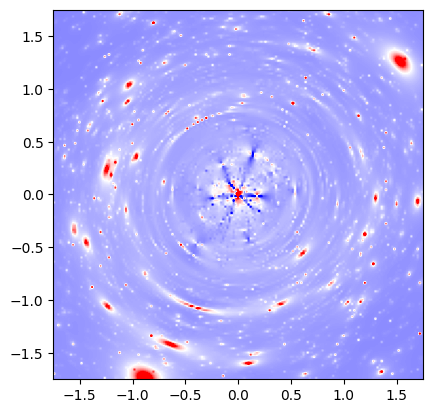

DECOUPLED


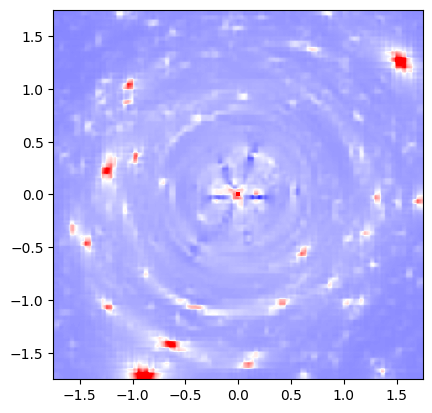

In [5]:
lens_model_decoupled = LensModel(**kwargs_class_setup)
# can optionally do this at lower resolution to save some time (or you can skip this cell altogether... )
grid_size = window_size
grid_resolution = 0.02
xx, yy, _, npix = setup_grids(grid_size, grid_resolution)
kappa_macro = lens_model_macro.kappa(xx, yy, kwargs_lens_macro).reshape(npix,npix)
from time import time
t0 = time()
kappa_full_true = lens_model_multiplane.kappa(xx, yy, kwargs_lens).reshape(npix,npix)
print('time for full ray-tracing: ', time() - t0)
t0 = time()
kappa_full_decoupled = lens_model_decoupled.kappa(xx, yy, kwargs_lens_macro).reshape(npix,npix)
print('time for decoupled ray-tracing: ', time() - t0)

extent = [-grid_size/2, grid_size/2, -grid_size/2, grid_size/2]
print('EXACT')
plt.figure()
delta_kappa = kappa_full_true-kappa_macro
vminmax = 0.2
plt.imshow(delta_kappa,cmap='bwr',vmin=-vminmax,vmax=vminmax,origin='lower',extent=extent)
plt.show()

print('DECOUPLED')
plt.figure()
delta_kappa = kappa_full_decoupled-kappa_macro
plt.imshow(delta_kappa,cmap='bwr',vmin=-vminmax,vmax=vminmax,origin='lower',extent=extent)
plt.show()

### Initialize the fit to the imaging data

In [6]:
source_model_list = ['SERSIC_ELLIPSE']
joint_source_with_point_source = [[0, 0]] 
lens_light_model_list = ['SERSIC_ELLIPSE']
point_source_list = ['LENSED_POSITION']

kwargs_model = {'lens_model_list': lens_model_list_macro,
                'lens_redshift_list': [zlens]*2, 
                'z_source': zsource,
                'kwargs_lens_eqn_solver': {'arrival_time_sort': False},
                # to specify this option in the lens modeling, all we have to do is specify 
                # decouple_multi_plane=True, kwargs_multiplane_model=kwargs_class_setup['kwargs_multiplane_model'],
                # and multi_plane=True. See the cell #4 for how to set up kwargs_class_setup['kwargs_multiplane_model']
                'multi_plane': True, 
                'decouple_multi_plane': True,
                'kwargs_multiplane_model': kwargs_class_setup['kwargs_multiplane_model'],
                'source_light_model_list': source_model_list,
                'lens_light_model_list': ['SERSIC_ELLIPSE'],
                'point_source_model_list': ['LENSED_POSITION'],
                'additional_images_list': [False],
                'fixed_magnification_list': [False],  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
}

num_source_model = len(source_model_list)
kwargs_constraints = {'joint_source_with_point_source': joint_source_with_point_source,
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR'
                      }

prior_lens = None
prior_lens_light = None
kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': True,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': False,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'prior_lens': prior_lens,
                     'prior_lens_light': prior_lens_light,
                     'image_likelihood_mask_list': [mask]
                     }

#'image_likelihood_mask_list': [likelihood_mask],
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
n_max_epl = 1
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
shapelets_init = {'amp': 1.0, 'beta': 1e-1, 'n_max': n_max_epl, 'center_x': 0.0, 'center_y': 0.0}
shapelets_sigma = {'amp': 10.0, 'beta': 0.2, 'n_max': 1.0, 'center_x': 0.1, 'center_y': 0.1}
shapelets_min = {'amp': 0.00001, 'beta': 1e-10, 'n_max': 1.0, 'center_x': -1.0, 'center_y': -1.0}
shapelets_max = {'amp': 1000.0, 'beta': 100.0, 'n_max': 10.0, 'center_x': 1.0, 'center_y': 1.0}

kwargs_lens_init = kwargs_lens_macro
kwargs_source_init = [{'amp': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.01, 'e2': 0.04, 'R_sersic': 0.1, 'n_sersic': 4.0}] + [shapelets_init]
kwargs_lens_light_init = [{'amp': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.01, 'e2': 0.04, 'R_sersic': 0.1, 'n_sersic': 4.0}]
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.05, 'center_x': 0.1, 'center_y': 0.1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.05, 'a4_a': 0.01}, 
                    {'gamma1': 0.02, 'gamma2': 0.02}] 
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'e1': 0.4, 'e2': 0.4, 'center_x': .1, 'center_y': 0.1}]+[shapelets_sigma]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.4, 'e2': 0.4, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [1e-5] * 4, 'dec_image': [1e-5] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.05, 'center_x': -10.0, 'center_y': -10.0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'a4_a': -0.1}, 
                    {'gamma1': -0.5, 'gamma2': -0.5}] 
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]+[shapelets_min]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 2.0, 'center_x': 10.0, 'center_y': 10.0, 'e1': 0.5, 'e2': 0.5, 'gamma': 3.5, 'a4_a': 0.1}, 
                    {'gamma1': 0.5, 'gamma2': 0.5}] 
kwargs_upper_source = [{'R_sersic': 10.0, 'n_sersic': 10.0, 'e1': 0.5, 'e2': 0.5,'center_x': 10, 'center_y': 10}]+[shapelets_max]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 10.0, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

# keeping parameters fixed
kwargs_lens_fixed = [{}, {'ra_0': 0.0, 'dec_0': 0.0}]
kwargs_source_fixed = [{}, {'n_max': 1, 'amp': 0.0}]
kwargs_lens_light_fixed = [{}]
kwargs_ps_fixed = [{}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, 
                              kwargs_constraints, kwargs_likelihood, kwargs_params)

nthreads = 8
#if include_shapelets and n_max_epl > 0:
#     fitting_kwargs_list = [
#         ['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 150, 'threadCount': nthreads}],
#         ['update_settings', {'source_remove_fixed': [[1, ['n_max', 'amp']]]}],
#         ['update_settings', {'source_add_fixed': [[1, ['n_max'], [n_max_epl]]]}],
#         ['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 250, 'threadCount': nthreads}],
#         ['MCMC', {'n_burn': 250, 'n_run': 100, 'walkerRatio': 4, 'sigma_scale': 0.1, 'threadCount': nthreads}]
#                           ]
#else:
fitting_kwargs_list = [
        ['PSO', {'sigma_scale': 1., 'n_particles': 20, 'n_iterations': 100, 'threadCount': nthreads}],
       # ['MCMC', {'n_burn': 0, 'n_run': 10, 'walkerRatio': 4, 'sigma_scale': 0.1, 'threadCount': nthreads}]
                          ]
        

### Now we can reconstruct the lens and source by applying the non-linear deflection field from background halos. 

This is not quite as fast as a single-plane computation, but it is hundreds (thousands?) of times faster than full ray-tracing

In [7]:
from time import time
# Fit the smooth lens system to the observations (which include substructure)
t0 = time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
tend = time()
print('time ellapsed (min): ', (tend - t0)/60)
kwargs_result = fitting_seq.best_fit()

total_number_ray_tracing_calculations = fitting_kwargs_list[0][1]['n_iterations'] * fitting_kwargs_list[0][1]['n_particles']
time_per_PSO_iteration_with_approx = (tend - t0) / total_number_ray_tracing_calculations
print('TIME PER PSO ITERATION (sec): ', time_per_PSO_iteration_with_approx)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0740320001408232 reduced X^2 of best position
-2616.878968343116 log likelihood
4873 effective number of data points
[{'theta_E': 1.0546251736654635, 'gamma': 2.0716666282114264, 'e1': -0.05798108583252689, 'e2': 0.15375094557246002, 'center_x': 0.0008831240285507121, 'center_y': -0.003820008793678608}, {'gamma1': 0.060279537936269834, 'gamma2': 0.04216018594451017, 'ra_0': 0.0, 'dec_0': 0.0}] lens result
[{'amp': 1, 'R_sersic': 0.11347596935013865, 'n_sersic': 4.119066113460525, 'e1': 0.0035245389062357416, 'e2': 0.09208613769556334, 'center_x': 0.04169650803097652, 'center_y': -0.04518460976726414}] source result
[{'amp': 1, 'R_sersic': 0.27520533939162467, 'n_sersic': 4.400376672159496, 'e1': -0.04078841866634461, 'e2': 0.03534915866070375, 'center_x': -0.0008163161124705946, 'center_y': -0.0014978095583917696}] lens light result
[{'ra_image': array([ 1.05902193, -1.00770286, -0.48936789,  0.094

dict_keys(['lens_model_list', 'lens_redshift_list', 'z_source', 'kwargs_lens_eqn_solver', 'multi_plane', 'decouple_multi_plane', 'kwargs_multiplane_model', 'source_light_model_list', 'lens_light_model_list', 'point_source_model_list', 'additional_images_list', 'fixed_magnification_list'])
-1.0681138646298431 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0681138646298431
(21, ['gamma_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image'])


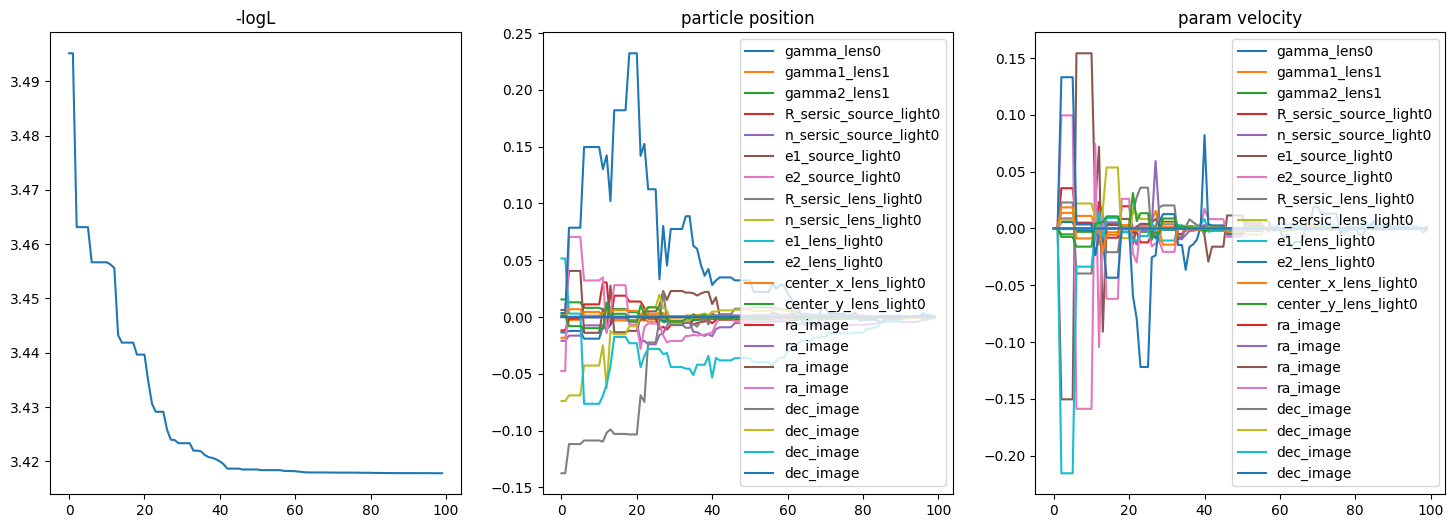

<Figure size 640x480 with 0 Axes>

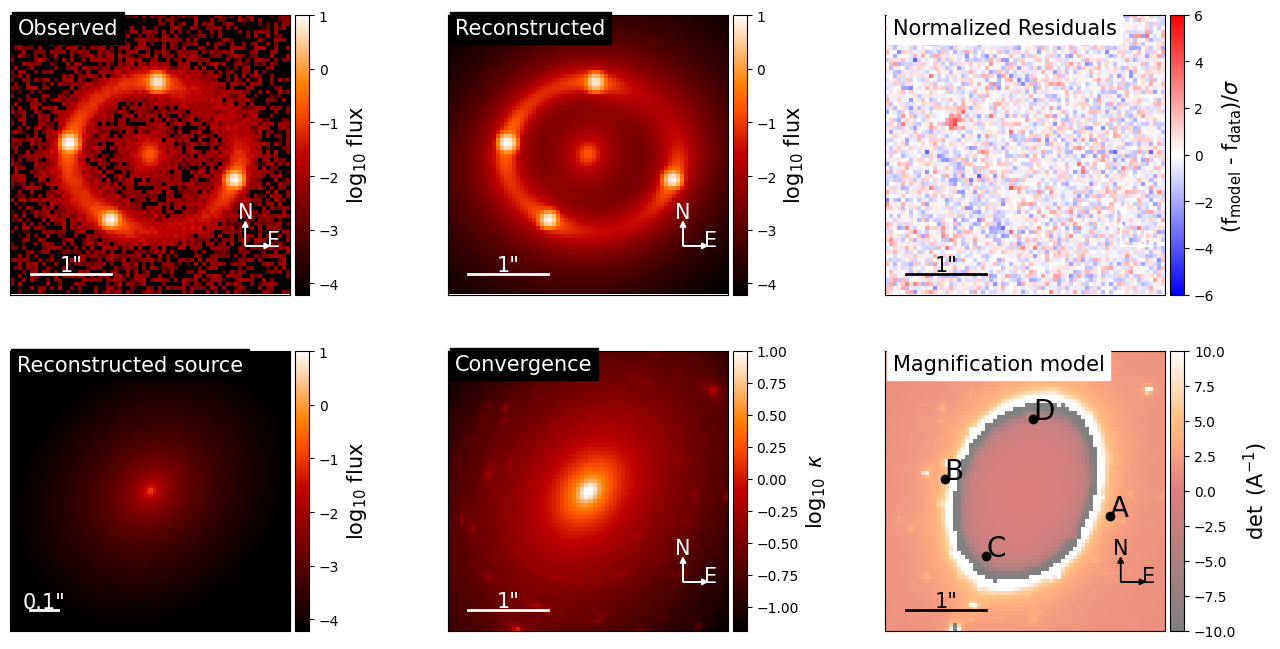

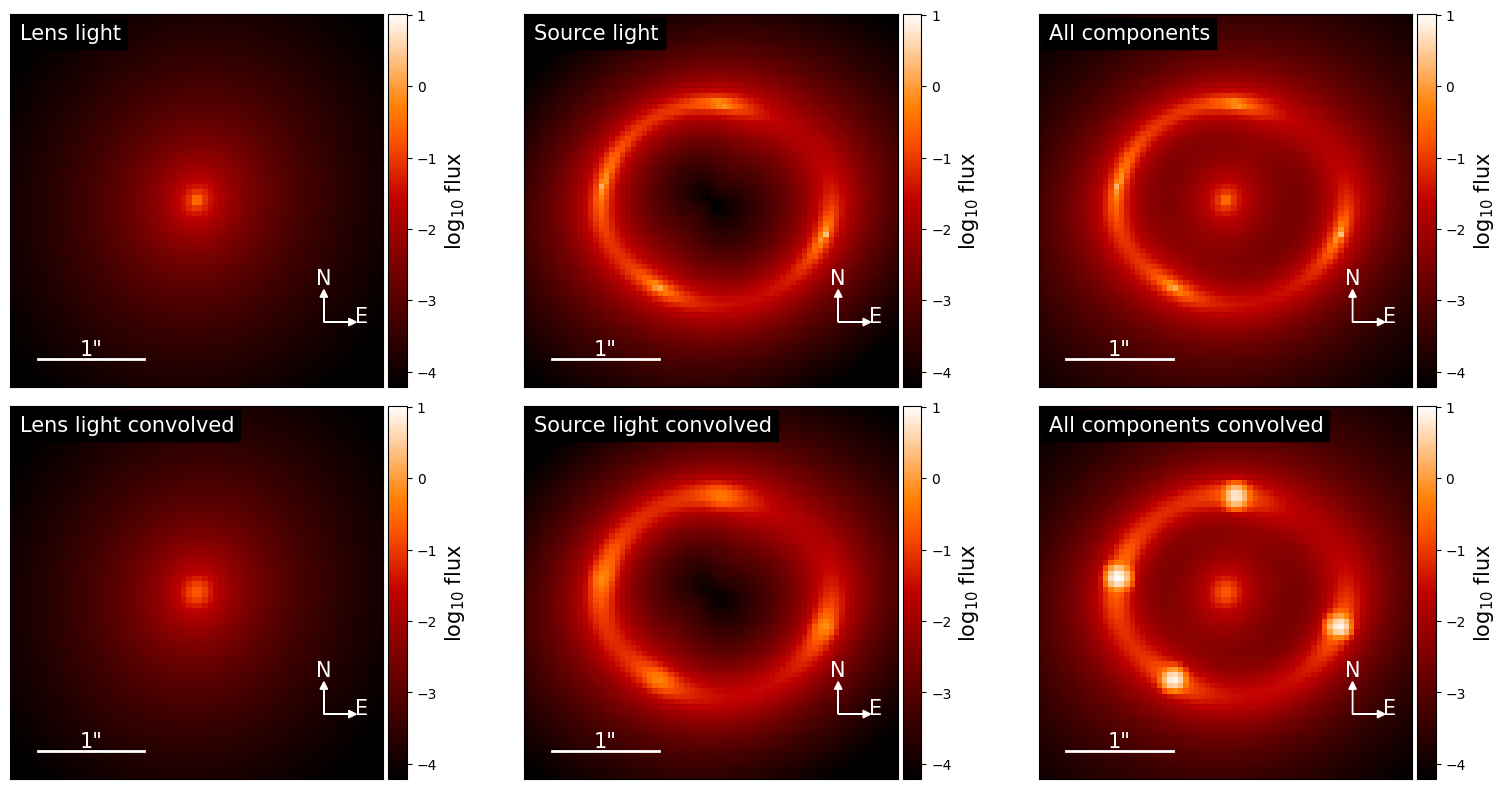

{'kwargs_lens': [{'theta_E': 1.0546251736654635, 'gamma': 2.0716666282114264, 'e1': -0.05798108583252689, 'e2': 0.15375094557246002, 'center_x': 0.0008831240285507121, 'center_y': -0.003820008793678608}, {'gamma1': 0.060279537936269834, 'gamma2': 0.04216018594451017, 'ra_0': 0.0, 'dec_0': 0.0}], 'kwargs_source': [{'amp': 17.886640434717926, 'R_sersic': 0.11347596935013865, 'n_sersic': 4.119066113460525, 'e1': 0.0035245389062357416, 'e2': 0.09208613769556334, 'center_x': 0.04169650803097652, 'center_y': -0.04518460976726414}], 'kwargs_lens_light': [{'amp': 4.202423655134301, 'R_sersic': 0.27520533939162467, 'n_sersic': 4.400376672159496, 'e1': -0.04078841866634461, 'e2': 0.03534915866070375, 'center_x': -0.0008163161124705946, 'center_y': -0.0014978095583917696}], 'kwargs_ps': [{'ra_image': array([ 1.05902193, -1.00770286, -0.48936789,  0.09488725]), 'dec_image': array([-0.31995728,  0.1378945 , -0.82003614,  0.89816304]), 'point_amp': array([41.58094704, 61.32360158, 43.04430668, 37.96

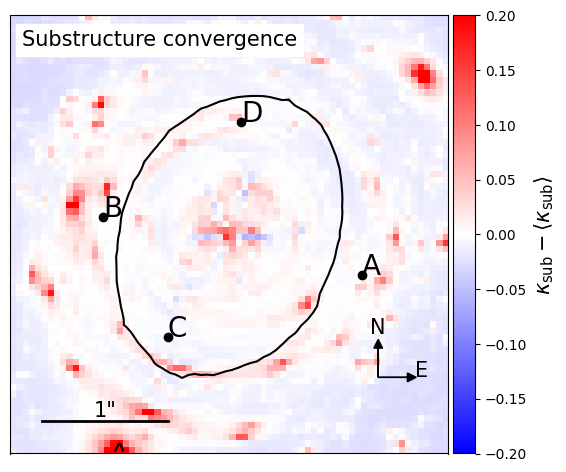

In [8]:
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
print(kwargs_model.keys())
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat",
                     fast_caustic=True)

param_class = fitting_seq.param_class
print(param_class.num_param())
#print(chain_list)

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
#f.tight_layout()
#f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
#plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

fig = plt.figure()
fig.set_size_inches(6, 6)
ax = plt.subplot(111)
kwargs_plot = {'ax': ax,
               'index_macromodel': [0, 1], 
              'with_critical_curves': True,
              'v_min': -0.2,'v_max': 0.2}
modelPlot.substructure_plot(band_index=0, **kwargs_plot)
print(kwargs_result)

### The following cell will attempt the same calculation with exact ray tracing. 

Actually running this cell with a large number of particles and PSO iterations would take an eternity will exact ray tracing

In [9]:
source_model_list = ['SERSIC_ELLIPSE']
joint_source_with_point_source = [[0, 0]] 
lens_light_model_list = ['SERSIC_ELLIPSE']
point_source_list = ['LENSED_POSITION']

kwargs_model = {'lens_model_list': lens_model_list_macro + list(lens_model_list_halos),
                'lens_redshift_list': [zlens]*2 + list(redshift_array_halos), 
                'z_source': zsource,
                'kwargs_lens_eqn_solver': {'arrival_time_sort': False},
                'multi_plane': True, 
                'decouple_multi_plane': False,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': ['SERSIC_ELLIPSE'],
                'point_source_model_list': ['LENSED_POSITION'],
                'additional_images_list': [False],
                'fixed_magnification_list': [False],  # list of bools (same length as point_source_type_list). If True, magnification ratio of point sources is fixed to the one given by the lens model 
}

num_source_model = len(source_model_list)
kwargs_constraints = {'joint_source_with_point_source': joint_source_with_point_source,
                      'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR'
                      }

prior_lens = None
prior_lens_light = None
kwargs_likelihood = {'check_bounds': True,
                     'force_no_add_image': True,
                     'source_marg': False,
                     'image_position_uncertainty': 0.004,
                     'check_matched_source_position': False,
                     'source_position_tolerance': 0.001,
                     'source_position_sigma': 0.001,
                     'prior_lens': prior_lens,
                     'prior_lens_light': prior_lens_light,
                     'image_likelihood_mask_list': [mask]
                     }

#'image_likelihood_mask_list': [likelihood_mask],
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
n_max_epl = 1
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
shapelets_init = {'amp': 1.0, 'beta': 1e-1, 'n_max': n_max_epl, 'center_x': 0.0, 'center_y': 0.0}
shapelets_sigma = {'amp': 10.0, 'beta': 0.2, 'n_max': 1.0, 'center_x': 0.1, 'center_y': 0.1}
shapelets_min = {'amp': 0.00001, 'beta': 1e-10, 'n_max': 1.0, 'center_x': -1.0, 'center_y': -1.0}
shapelets_max = {'amp': 1000.0, 'beta': 100.0, 'n_max': 10.0, 'center_x': 1.0, 'center_y': 1.0}

kwargs_lens_init = kwargs_lens_macro
kwargs_source_init = [{'amp': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.01, 'e2': 0.04, 'R_sersic': 0.1, 'n_sersic': 4.0}] + [shapelets_init]
kwargs_lens_light_init = [{'amp': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.01, 'e2': 0.04, 'R_sersic': 0.1, 'n_sersic': 4.0}]
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.05, 'center_x': 0.1, 'center_y': 0.1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.05, 'a4_a': 0.01}, 
                    {'gamma1': 0.02, 'gamma2': 0.02}] 
kwargs_source_sigma = [{'R_sersic': 0.1, 'n_sersic': .5, 'e1': 0.4, 'e2': 0.4, 'center_x': .1, 'center_y': 0.1}]+[shapelets_sigma]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.2, 'e1': 0.4, 'e2': 0.4, 'center_x': .1, 'center_y': 0.1}]
kwargs_ps_sigma = [{'ra_image': [1e-5] * 4, 'dec_image': [1e-5] * 4}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.05, 'center_x': -10.0, 'center_y': -10.0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'a4_a': -0.1}, 
                    {'gamma1': -0.5, 'gamma2': -0.5}] 
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]+[shapelets_min]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 2.0, 'center_x': 10.0, 'center_y': 10.0, 'e1': 0.5, 'e2': 0.5, 'gamma': 3.5, 'a4_a': 0.1}, 
                    {'gamma1': 0.5, 'gamma2': 0.5}] 
kwargs_upper_source = [{'R_sersic': 10.0, 'n_sersic': 10.0, 'e1': 0.5, 'e2': 0.5,'center_x': 10, 'center_y': 10}]+[shapelets_max]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 10.0, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

# keeping parameters fixed
kwargs_lens_fixed = [{}, {'ra_0': 0.0, 'dec_0': 0.0}]
kwargs_source_fixed = [{}, {'n_max': 1, 'amp': 0.0}]
kwargs_lens_light_fixed = [{}]
kwargs_ps_fixed = [{}]

# now we will fix the lens model parameters for all DM halos 
for i in range(0, len(lens_model_list_halos)):
    kwargs_halo = deepcopy(kwargs_halos[i])
    kwargs_lens_init.append(kwargs_halo)
    kwargs_lens_sigma.append(kwargs_halo)
    kwargs_lens_fixed.append(kwargs_halo)
    kwargs_lower_lens.append(kwargs_halo)
    kwargs_upper_lens.append(kwargs_halo)
    
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_lens_fixed, kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, kwargs_source_fixed, kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_lens_light_fixed, kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_ps_fixed, kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, 
                              kwargs_constraints, kwargs_likelihood, kwargs_params)

nthreads = 8
#if include_shapelets and n_max_epl > 0:
#     fitting_kwargs_list = [
#         ['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 150, 'threadCount': nthreads}],
#         ['update_settings', {'source_remove_fixed': [[1, ['n_max', 'amp']]]}],
#         ['update_settings', {'source_add_fixed': [[1, ['n_max'], [n_max_epl]]]}],
#         ['PSO', {'sigma_scale': 1., 'n_particles': 50, 'n_iterations': 250, 'threadCount': nthreads}],
#         ['MCMC', {'n_burn': 250, 'n_run': 100, 'walkerRatio': 4, 'sigma_scale': 0.1, 'threadCount': nthreads}]
#                           ]
#else:
fitting_kwargs_list = [
        ['PSO', {'sigma_scale': 1., 'n_particles': 2, 'n_iterations': 2, 'threadCount': nthreads}],
        #['MCMC', {'n_burn': 0, 'n_run': 10, 'walkerRatio': 4, 'sigma_scale': 0.1, 'threadCount': nthreads}]
                          ]
        

In [10]:
from time import time
# Fit the smooth lens system to the observations (which include substructure)
t0 = time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
tend = time()
print('time ellapsed (min): ', (tend - t0)/60)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
Max iteration reached! Stopping.
-1.2330252581821952 reduced X^2 of best position
-3004.266041560919 log likelihood
4873 effective number of data points
[{'theta_E': 1.0665629170518796, 'gamma': 2.03, 'e1': -0.1269239251007969, 'e2': 0.1873882626547481, 'center_x': -0.010140270572857643, 'center_y': 0.0008796161688975319}, {'gamma1': 0.03142154459331258, 'gamma2': 0.055791455755971026, 'ra_0': 0.0, 'dec_0': 0.0}, {'Rs': 0.0037277021, 'alpha_Rs': 0.0008469293, 'r_trunc': 0.9364579673735577, 'center_x': -1.5899, 'center_y': -3.7662}, {'Rs': 0.0020756691, 'alpha_Rs': 0.0003926215, 'r_trunc': 0.6031979132016537, 'center_x': 1.2361, 'center_y': -2.2966}, {'Rs': 0.0079144162, 'alpha_Rs': 0.0022033018, 'r_trunc': 1.628247833434707, 'center_x': -1.572, 'center_y': -2.0653}, {'Rs': 0.0034922364, 'alpha_Rs': 0.0007531959, 'r_trunc': 0.8815166849533576, 'center_x': 1.1186, 'center_y': -1.8403}, {'Rs': 0.002499369, 'alpha_Rs': 0.0003015861, 'r_trunc': 0.5769581955451332, 'cen

time ellapsed (min):  3.500365420182546


In [11]:
total_number_ray_tracing_calculations = fitting_kwargs_list[0][1]['n_iterations'] * fitting_kwargs_list[0][1]['n_particles']
time_per_PSO_iteration_without_approx = (tend - t0) / total_number_ray_tracing_calculations
print('TIME PER PSO ITERATION (sec): ', time_per_PSO_iteration_without_approx)
print("IMPROVEMENT FACTOR: ", time_per_PSO_iteration_without_approx/time_per_PSO_iteration_with_approx)

TIME PER PSO ITERATION (sec):  52.50548130273819
IMPROVEMENT FACTOR:  1228.5429035990269
